# **News Category Classification**
## —— Identifying News Articles for Contextual Advertising Using Supervised Machine Learning

## **Table of Contents**
### I. Project Background
### II. Setting up the work environment
### III. Importing the data set
### IV. Data Cleaning and Preparation
### V. Baseline Model
### VI. Improving Model
### VII. Finalizing Model
### VIII. Model Evaluation & Discussion

<br>

--------------------------------------------------------------------------

<br>

### **I. Project Background**

Imagine you're working at a media buying company, Chrishare. They have a new client, Theragun. 

Theragun knows that consumers who value health and wellness are more likely to consider, and ultimately buy their product. So, they’d like to find health and wellness news around the web to advertise on. Their goal with their media campaign is to identify as many news articles that mention health and wellness as possible. 

Your challenge now is to build a deep learning algorithm that predicts the probability that a news story is about health and wellness.

<br>

--------------------------------------------------------------------------

<br>

### **II. Setting up the work environment**

In [ ]:
import os

# Setting up ktrain as a wrapper for Tensorflow, Keras, and Huggingface Transformers
try:
  import ktrain
except:
  !pip install ktrain
  os.kill(os.getpid(), 9)
import ktrain

# Importing common libraries for data analysis
import pandas as pd
import numpy as np

In [ ]:
# Importing datetime for dealing with dates
from datetime import datetime

In [ ]:
# Importing sklearn for splitting data into train and validation sets
from sklearn.model_selection import train_test_split

In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setting Google Colab Runtime to use GPU, which will speed up deep learning significantly
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Mar 16 23:21:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

<br>

--------------------------------------------------------------------------

<br>

### **III. Importing the data set**

In [ ]:
# Importing the data from Google Drive
reviews = pd.read_json("drive/MyDrive/news_category_trainingdata.json")

In [ ]:
# Inspecting the data
reviews.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [ ]:
# Checking data info
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200853 entries, 0 to 200852
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   category           200853 non-null  object        
 1   headline           200853 non-null  object        
 2   authors            200853 non-null  object        
 3   link               200853 non-null  object        
 4   short_description  200853 non-null  object        
 5   date               200853 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 10.7+ MB


In [ ]:
reviews.category.value_counts(normalize = True)

POLITICS          0.163000
WELLNESS          0.088756
ENTERTAINMENT     0.079949
TRAVEL            0.049225
STYLE & BEAUTY    0.048040
PARENTING         0.043201
HEALTHY LIVING    0.033328
QUEER VOICES      0.031436
FOOD & DRINK      0.030998
BUSINESS          0.029559
COMEDY            0.025765
SPORTS            0.024316
BLACK VOICES      0.022544
HOME & LIVING     0.020886
PARENTS           0.019691
THE WORLDPOST     0.018242
WEDDINGS          0.018177
WOMEN             0.017376
IMPACT            0.017222
DIVORCE           0.017057
CRIME             0.016953
MEDIA             0.014015
WEIRD NEWS        0.013293
GREEN             0.013054
WORLDPOST         0.012840
RELIGION          0.012726
STYLE             0.011222
SCIENCE           0.010844
WORLD NEWS        0.010839
TASTE             0.010435
TECH              0.010366
MONEY             0.008499
ARTS              0.007513
FIFTY             0.006975
GOOD NEWS         0.006960
ARTS & CULTURE    0.006667
ENVIRONMENT       0.006587
C

#### **Summary of Data Set Observations**
1. Looks like we have no missing data that's in the form of an empty space.
2. The data are of the right types (text -> object, date -> datetime64).
3. Wellness and healthy living together account for about 12% of the data.
4. Note that "Category" is our y (target) variable, and the other columns can be predictors.

<br>

--------------------------------------------------------------------------

<br>

### **IV. Data Cleaning and Preparation**

##### **1. Combining Text Columns**
Most machine learning tools in Python accept one field/column/string. So we have to merge our two text columns. We will separate them by adding a space as well.

In [ ]:
reviews['combined_text'] = reviews['headline'] + ' ' + reviews['short_description']

##### **2. Encoding the Target Variable**
We will turn "HEALTHY LIVING" and "WELLNESS" categories into 1, and the rest into 0. And we will call this new column 'target'.

In [ ]:
# Setting up a lambda function for encoding our Category classes
encoder = lambda x: 1 if (x == 'HEALTHY LIVING' or x =='WELLNESS') else 0

# Creating a new column 'target' to hold the encoded values
reviews['target'] = reviews['category'].apply(encoder)

# Inspecting the changes
reviews.head()

,category,headline,authors,link,short_description,date,combined_text,target
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,0
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,0
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,0
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,0


In [ ]:
# Sanity checking to see if our encoding worked correctly
reviews.target.value_counts(normalize = True).values[1]

0.12208431041607544

In [ ]:
# Remember our raw data contained:
# WELLNESS          0.088756
# HEALTHY LIVING    0.033328

# Therefore WELLNESS + HEALTHY LIVING = 
0.088756 + 0.033328 == round(reviews.target.value_counts(normalize = True).values[1],6)
# Our encoder worked correctly

True

##### **3. Feature Engineering the Date variable**


The date variable itself, seems to be an unlikely candidate for classifying the target class. Afterall, why would a news article's category be affected by the date it is published? 

But if we visit a news stand, we will find certain magazines/news papers are published on different days of the week! For example, typically Business related articles are published Monday - Friday, while Food articles tend to be published closer to the Weekend.

In [ ]:
reviews.date.dt.day_name().value_counts()

Thursday     30753
Wednesday    30704
Friday       30635
Tuesday      30612
Monday       30228
Saturday     24272
Sunday       23649
Name: date, dtype: int64

In [ ]:
# We will create a new column called "day_of_week" to capture this information
reviews['day_of_week'] = reviews.date.dt.day_name()

reviews.head() # A quick search on Google reveals that 2018-05-26 was indeed a Saturday.

,category,headline,authors,link,short_description,date,combined_text,target,day_of_week
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,0,Saturday
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0,Saturday
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,0,Saturday
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,0,Saturday
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,0,Saturday


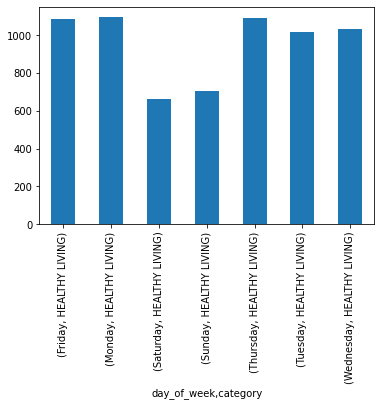

In [ ]:
health_subset = reviews[reviews.category == 'HEALTHY LIVING']

health_subset.groupby('day_of_week')['category'].value_counts().plot(kind = 'bar')

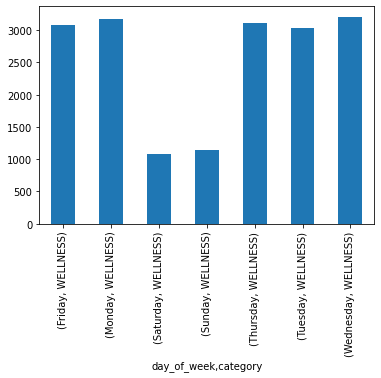

In [ ]:
wellness_subset = reviews[reviews.category == 'WELLNESS']

wellness_subset.groupby('day_of_week')['category'].value_counts().plot(kind = 'bar')

We can clearly see that Day of the Week indeed has an certain association with the category of article. It seems that both Wellness and Healthy Living articles are more likely to be published on the Weekdays than on Weekends.

In [ ]:
# We might benefit from grouping Saturday & Sunday into weekend and Others into weekdays
# Then concatentate the weekend/weekday identifier with 'combined_text' column for later training

# Setting up a lambda function for encoding our Category classes
week_encoder = lambda x: 'Weekend' if (x == 'Saturday' or x =='Sunday') else 'Weekday'

# Creating a new column 'week_group' to hold the encoded values
reviews['week_group'] = reviews['day_of_week'].apply(week_encoder)

# Concat with combined_text
reviews['combined_text'] += " " + reviews['week_group']

reviews.head()

,category,headline,authors,link,short_description,date,combined_text,target,day_of_week,week_group
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were 2 Mass Shootings In Texas Last Week...,0,Saturday,Weekend
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The 2...,0,Saturday,Weekend
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age 5...,0,Saturday,Weekend
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,0,Saturday,Weekend
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...,0,Saturday,Weekend


In [ ]:
reviews.combined_text[0]

'There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV She left her husband. He killed their children. Just another day in America. Weekend'

##### **4. Creating a balanced data set**
Typically we don't want to work with an imbalanced data set, as it could distort ML results/interpretations.

To create a balanced data set that includes all healthing living and wellness articles set sample_amount to the total number of those articles.

In [ ]:
sample_amount =  len(reviews[reviews["target"] == 1])
sample_amount

24521

In [ ]:
healthwellness = reviews[reviews['target'] == 1]
non_healthwellness = reviews[reviews['target'] == 0].sample(n=sample_amount, random_state = 42) # Note we could also set a random_state in the sample function.

reviews_balanced = pd.concat([healthwellness,non_healthwellness])

In [ ]:
reviews_balanced.describe() # We can see the mean of target = 0.5 which is as expected

,target
count,49042.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [ ]:
reviews_balanced.head() # There's no need to reset the index here, so we will keep the index as it is.

,category,headline,authors,link,short_description,date,combined_text,target,day_of_week,week_group
7578,HEALTHY LIVING,To The People Who Say ‘I’m Tired’ When Someone...,"The Mighty, ContributorWe face disability, dis...",https://www.huffingtonpost.com/entry/to-the-pe...,"When you feel like this, it’s important to kno...",2018-01-16,To The People Who Say ‘I’m Tired’ When Someone...,1,Tuesday,Weekday
7693,HEALTHY LIVING,Eating Shake Shack Made Me Feel Healthier Than...,"Colleen Werner, ContributorCampus Editor-at-Large",https://www.huffingtonpost.com/entry/eating-sh...,I can vividly remember the first time I felt f...,2018-01-12,Eating Shake Shack Made Me Feel Healthier Than...,1,Friday,Weekday
7747,HEALTHY LIVING,How To Stay Updated On The News Without Losing...,Lindsay Holmes,https://www.huffingtonpost.com/entry/anxiety-f...,Because it's only becoming more of a struggle.,2018-01-12,How To Stay Updated On The News Without Losing...,1,Friday,Weekday
7927,HEALTHY LIVING,27 Perfect Tweets About Whole30 That Will Make...,Lindsay Holmes,https://www.huffingtonpost.com/entry/tweets-ab...,"""The only Whole30 I want to participate in is ...",2018-01-10,27 Perfect Tweets About Whole30 That Will Make...,1,Wednesday,Weekday
7934,HEALTHY LIVING,The Real Reason Your Hands Are Always Cold,"Refinery29, ContributorThe #1 new-media brand ...",https://www.huffingtonpost.com/entry/the-real-...,"Essentially, your hands are kept warm thanks t...",2018-01-10,The Real Reason Your Hands Are Always Cold Ess...,1,Wednesday,Weekday


<br>

--------------------------------------------------------------------------

<br>

### **V. Baseline Model**

It is often useful to first establish a baseline model. We can use the results from the baseline model as a benchmark for future model improvements and iterations.

In [ ]:
# Saving target variable names
target_names = ['NOT HEALTH & WELLNESS','HEALTH & WELLNESS']

Our baseline model will be the 'distillbert-base-uncased' model. The reason for choosing this model is because it is a relatively small model, and should have fast training times. We could use other models such as BERT, but those are very large models and will take hours and hours to train, which is not feasible for this project.

#### **1. Setting up the transformer model**

I will set maxlen = 100, as 99th percentile length is 71. I will set max_features = 10000 to conserve training resources.

In [ ]:
# Let's try a distillbert-base-uncased transformer model and use this as our baseline model
train, val, preprocess = ktrain.text.texts_from_df(
    reviews_balanced,
    "combined_text",
    label_columns=["target"],
    val_df=None,
    max_features=10000,
    maxlen=100,
    val_pct=0.1,
    ngram_range=1,
    preprocess_mode="distilbert",
    verbose=1
)

['not_target', 'target']
        not_target  target
152864         0.0     1.0
130409         0.0     1.0
22597          1.0     0.0
44044          1.0     0.0
173831         1.0     0.0
['not_target', 'target']
        not_target  target
85385          1.0     0.0
90871          1.0     0.0
137044         0.0     1.0
33745          1.0     0.0
131161         0.0     1.0


Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

preprocessing train...
language: en
train sequence lengths:
	mean : 33
	95percentile : 59
	99percentile : 69


Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 34
	95percentile : 60
	99percentile : 71


In [ ]:
model_baseline = preprocess.get_classifier()
learner_baseline = ktrain.get_learner(model_baseline, train_data=train, val_data=val, batch_size=24)

Downloading:   0%|          | 0.00/363M [00:00<?, ?B/s]

#### **2. Finding a learning rate**

According to Google Language AI research (2019), learning rates between 2e-5 and 5e-5 tend to work well with most transformer models.

Here, we will use the Ktrain's learning-rate-finder for 5 epochs to estimate the optimal learning rate.

In [ ]:
learner_baseline.lr_find(max_epochs=5)

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
1839/1839 [==============================] - 900s 476ms/step - loss: 0.4997 - accuracy: 0.7620
Epoch 2/5
1839/1839 [==============================] - 885s 481ms/step - loss: 0.2418 - accuracy: 0.9062
Epoch 3/5
1839/1839 [==============================] - 881s 479ms/step - loss: 0.5719 - accuracy: 0.6230
Epoch 4/5
1839/1839 [==============================] - 462s 251ms/step - loss: 6.4925 - accuracy: 0.5033


done.
Please invoke the Learner.lr_plot() method to visually inspect the loss plot to help identify the maximal learning rate associated with falling loss.


We can see below, that a learning rate of 10^-4 is optimal, we will use this in our later training.

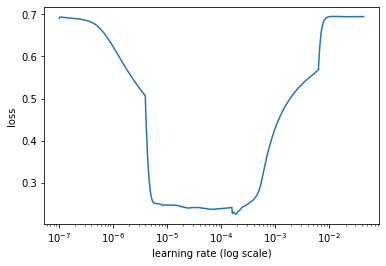

In [ ]:
learner_baseline.lr_plot()

#### **3. Model Training**

Here we will use the autofit training method, other options include the one-cycle policy.

In [ ]:
history=learner_baseline.autofit(
    1e-4,
    checkpoint_folder='checkpoint',
    epochs=5,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 0.0001...
Epoch 1/5
1840/1840 [==============================] - 920s 493ms/step - loss: 0.1534 - accuracy: 0.9431 - val_loss: 0.1974 - val_accuracy: 0.9229
Epoch 2/5
1840/1840 [==============================] - 920s 493ms/step - loss: 0.1030 - accuracy: 0.9642 - val_loss: 0.2201 - val_accuracy: 0.9242
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


In [ ]:
predictor_baseline = ktrain.get_predictor(learner_baseline.model, preproc=preprocess)

In [ ]:
predictor_baseline.save("drive/MyDrive/MSDSTextClassification_Final_distlbert_weekend.healthwellness")

#### **Summary of Baseline Model Results**
1. The average training time is 920s, or 15m20s.
2. The validation loss is 0.1974, with a validation accuracy of 0.9229 (from best epoch).

<br>

--------------------------------------------------------------------------

<br>

### **VI. Improving Model**

#### **1. Trying a different training policy**

In [ ]:
# using the fit_onecycle policy with 3 epochs
history = learner_baseline.fit_onecycle(1e-4, 3) 



begin training using onecycle policy with max lr of 0.0001...
Epoch 1/3
1840/1840 [==============================] - 973s 519ms/step - loss: 0.1400 - accuracy: 0.9484 - val_loss: 0.2258 - val_accuracy: 0.9107
Epoch 2/3
1840/1840 [==============================] - 966s 517ms/step - loss: 0.1233 - accuracy: 0.9547 - val_loss: 0.2472 - val_accuracy: 0.9127
Epoch 3/3
1840/1840 [==============================] - 965s 518ms/step - loss: 0.0443 - accuracy: 0.9855 - val_loss: 0.3199 - val_accuracy: 0.9138


As we can see, the model's performance did not improve.

#### **2. Trying a different learning rate**
Let's try using Google's guideline rate of 2e-5.

In [ ]:
# Now using google's research
history=learner_baseline.autofit(
    2e-5,
    checkpoint_folder='checkpoint',
    epochs=5,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 2e-05...
Epoch 1/5
1840/1840 [==============================] - 970s 519ms/step - loss: 0.0139 - accuracy: 0.9962 - val_loss: 0.4213 - val_accuracy: 0.9152
Epoch 2/5
1840/1840 [==============================] - 966s 518ms/step - loss: 0.0085 - accuracy: 0.9978 - val_loss: 0.4735 - val_accuracy: 0.9138
Epoch 2: early stopping
Weights from best epoch have been loaded into model.


The new learning rate did not improve our model's performance, but it is not far behind either.

Does this mean we should disregard Google's research completely? No, because our data is relatively small, so we can run a learning-rate search to find the optimal learning rate relatively quickly. But imagine if we had billions of observations, then our approach would consume a lot of computing resources and take a long time to run. So instead of trying the best learning rate, Google's rule of thumb (2e-2 ~ 2e-5) offers us a pretty good learning rate, that works well on most models, and the best thing of all, it consumes no resources to find!

### **Trying a different model: DistilRoBERTa-base**


In [ ]:
# Trying distilroberta-base

# Step 1: Creating training and test sets (using 0.1 validation proportion)
X_train, X_val, y_train, y_val = train_test_split(X = reviews_balanced.drop('target', axis = 1), y = reviews_balanced.target, test_size = 0.1, random_state = 42)

# Step 2: Create a Transformer instance
transformer = ktrain.text.Transformer('distilroberta-base', maxlen = 100, classes = target_names)

# Step 3: Preprocessing the data sets
train_d = transformer.preprocess_train(X_train.combined_text.to_list(), y_train.to_list())
val_d = transformer.preprocess_test(X_val.combined_text.to_list(), y_val.to_list())

# Step 4: Create a model and wrap in learner
model_roberta = transformer.get_classifier()
learner_roberta = ktrain.get_learner(model_roberta, train_data = train_d, val_data = val_d, batch_size = 24)

/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:422: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')


preprocessing train...
language: en
train sequence lengths:
	mean : 33
	95percentile : 59
	99percentile : 69


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 33
	95percentile : 59
	99percentile : 70


Downloading:   0%|          | 0.00/487M [00:00<?, ?B/s]

simulating training for different learning rates... this may take a few moments...
Epoch 1/5
1839/1839 [==============================] - 930s 492ms/step - loss: 0.4514 - accuracy: 0.7666
Epoch 2/5
1839/1839 [==============================] - 918s 499ms/step - loss: 0.2484 - accuracy: 0.9029
Epoch 3/5
1839/1839 [==============================] - 919s 500ms/step - loss: 0.6450 - accuracy: 0.5577
Epoch 4/5
1839/1839 [==============================] - 307s 167ms/step - loss: 1.2078 - accuracy: 0.4935


done.
Visually inspect loss plot and select learning rate associated with falling loss


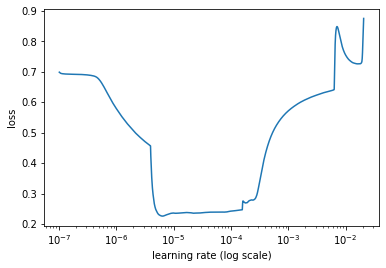

In [ ]:
learner_roberta.lr_find(show_plot = True, max_epochs = 5)

The optimal learning rate is around 1e-5.

In [ ]:
history=learner_roberta.autofit(
    1e-5,
    checkpoint_folder='checkpoint',
    epochs=5,
    early_stopping=True
)



begin training using triangular learning rate policy with max lr of 1e-05...
Epoch 1/5
1840/1840 [==============================] - 987s 515ms/step - loss: 0.2781 - accuracy: 0.8817 - val_loss: 0.1942 - val_accuracy: 0.9280
Epoch 2/5
1840/1840 [==============================] - 955s 512ms/step - loss: 0.1934 - accuracy: 0.9248 - val_loss: 0.1872 - val_accuracy: 0.9317
Epoch 3/5
1840/1840 [==============================] - 956s 513ms/step - loss: 0.1671 - accuracy: 0.9367 - val_loss: 0.1816 - val_accuracy: 0.9337
Epoch 4/5
1840/1840 [==============================] - 951s 510ms/step - loss: 0.1425 - accuracy: 0.9468 - val_loss: 0.1856 - val_accuracy: 0.9358
Epoch 4: early stopping
Weights from best epoch have been loaded into model.


As we can see, the DistilRoBERTa-base version of our model has improved our performance.

#### **Summary of Model Improvements**
1. We found that the DistilRoBERTa-base model improved upon our previous Baseline model.
2. The best epoch of the DistilRoBERTa-base model resulted in a validation loss of 0.1816, and a validation accuracy of 0.9337.
3. The improvement came with an increase in training time, from 15m20s to 15m56s.

<br>

--------------------------------------------------------------------------

<br>

### **VII. Finalizing Model**

Creating a predictor based on the best trained model, and saving a copy on Google Drive.

In [ ]:
predictor_roberta = ktrain.get_predictor(learner_roberta.model, preproc=transformer)
predictor_roberta.save("drive/MyDrive/MSDSTextClassification_Final_distilroberta.healthwellness")

<br>

--------------------------------------------------------------------------

<br>

### **VIII. Model Evaluation & Discussion**

#### **1. Classification Report**

In [ ]:
validation = learner_roberta.validate(val_data=val_d, print_report=True)

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      2517
           1       0.92      0.95      0.93      2388

    accuracy                           0.93      4905
   macro avg       0.93      0.93      0.93      4905
weighted avg       0.93      0.93      0.93      4905



Based on the classification result of our DistilRoBERTa model, we can see that the model has relatively good performance. It has an accuracy of 93%, an overall recall, precision and F1 score of 93%.

In addition, on both the positive and negative classes, the model's precision and recall are all above 92%. 

#### **2. Predictions and Interpretation of results**

In [ ]:
!pip3 install -q git+https://github.com/amaiya/eli5@tfkeras_0_10_1

Let's extract some random articles from the data set and see how well our model predicts the categories of these articles.

In [ ]:
demo_data = reviews_balanced.sample(5, random_state = 99)
demo_data.head()

,category,headline,authors,link,short_description,date,combined_text,target,day_of_week,week_group
111964,HEALTHY LIVING,"Experiencing the Beyond: Transcending, the Fas...","Rona Abramson, Contributor",https://www.huffingtonpost.com/entry/transcend...,"""Exploring the explorer"" is critical. Diving d...",2014-09-15,"Experiencing the Beyond: Transcending, the Fas...",1,Monday,Weekday
133645,WELLNESS,The 7 Lessons Life Will Teach You,"Dr. Carmen Harra, Contributor\nDr. Harra is a ...",https://www.huffingtonpost.com/entry/life-less...,"Far superior to a formal education, life is ou...",2014-01-14,The 7 Lessons Life Will Teach You Far superior...,1,Tuesday,Weekday
126182,WELLNESS,Mike Posner and Breaking the Stigma of Mental ...,"Kyle McMahon, Contributor\nSelf Improvement or...",https://www.huffingtonpost.com/entry/post_us_5...,"Codi, my friend that had attended the show wit...",2014-04-04,Mike Posner and Breaking the Stigma of Mental ...,1,Friday,Weekday
191816,WELLNESS,WATCH: Life Coach Terri Cole's Tips For Overco...,,https://www.huffingtonpost.com/entry/terri-col...,Tell us: Did this video resonate with you? Com...,2012-05-04,WATCH: Life Coach Terri Cole's Tips For Overco...,1,Friday,Weekday
145886,CULTURE & ARTS,Best of Toronto 2013: Mais Darwazah's My Love ...,"E. Nina Rothe, Contributor\nCultural Activist",https://www.huffingtonpost.com/entry/best-of-t...,In her latest project My Love Awaits Me by the...,2013-09-07,Best of Toronto 2013: Mais Darwazah's My Love ...,0,Saturday,Weekend


In [ ]:
demo_news = demo_data.combined_text.to_list()
demo_news

['Experiencing the Beyond: Transcending, the Fast Track to Fulfillment "Exploring the explorer" is critical. Diving deep into our own consciousness and fathoming the essence of our own nature is where meditation can succeed in ways that other journeys can only hint at.  The key is in the process of transcending. Weekday',
 "The 7 Lessons Life Will Teach You Far superior to a formal education, life is our greatest teacher, sending us down winding paths to help us gain a profound awareness of our potential. We may be tested, but by recognizing the truth of our tests and applying necessary wisdom, we can triumph over every one of life's challenges. Weekday",
 'Mike Posner and Breaking the Stigma of Mental Health Codi, my friend that had attended the show with me, had know Mike for his party songs. As we were on our way home, he asked me what other "deep" songs Mike had that I could play for him. That is why we must not stop talking about it. Weekday',
 "WATCH: Life Coach Terri Cole's Tips

In [ ]:
for i, text in enumerate(demo_news):
  probs = predictor_roberta.predict(text, return_proba=True)
  print("---------------------------")
  print('The probability that this article is about Healthy Living or Wellness is %s' % probs[1])
  print(text)

---------------------------
The probability that this article is about Healthy Living or Wellness is 0.9947247
Experiencing the Beyond: Transcending, the Fast Track to Fulfillment "Exploring the explorer" is critical. Diving deep into our own consciousness and fathoming the essence of our own nature is where meditation can succeed in ways that other journeys can only hint at.  The key is in the process of transcending. Weekday
---------------------------
The probability that this article is about Healthy Living or Wellness is 0.99335045
The 7 Lessons Life Will Teach You Far superior to a formal education, life is our greatest teacher, sending us down winding paths to help us gain a profound awareness of our potential. We may be tested, but by recognizing the truth of our tests and applying necessary wisdom, we can triumph over every one of life's challenges. Weekday
---------------------------
The probability that this article is about Healthy Living or Wellness is 0.9768786
Mike Posne

We can see that not only does our model correctly predicts the categories of these 5 articles, it also does so confidently! We can see the probability of the correctly predicted articles being Healthy Living or Wellness are all above 97%!

Let's try to predict a "hard" case, where the word "healthy" exists inside a sentence that's not at all about Healthy Living or Wellness.

In [ ]:
predictor_roberta.explain('Diversity is the key to a healthy society. Here is what we need to do to make america a more equitable place to live for all.')

We can see that our model correctly predicts that the sentence is NOT HEALTH & WELLNESS!